#PART 1: ENVIRONMENT SETUP

# Data Preprocessing and Feature Engineering

**Project:** Satellite Imagery-Based Property Valuation  
**Notebook:** preprocessing.ipynb (Official Deliverable)  
**Author:** Rahul Yadav  
**Date:** December 2025

## Objectives:
This notebook performs comprehensive data preprocessing including:

1. **Data Loading and Exploration**
   - Loading training and test datasets
   - Understanding data structure and distributions
   - Identifying missing values and outliers

2. **Data Cleaning**
   - Removing duplicates and invalid entries
   - Handling missing values appropriately
   - Addressing data quality issues

3. **Feature Engineering**
   - Creating new meaningful features
   - Transforming skewed distributions
   - Encoding categorical variables

4. **Satellite Image Collection**
   - Downloading images for all properties
   - Creating image mappings
   - Verifying image quality

5. **Data Scaling and Normalization**
   - Fitting scalers on training data
   - Transforming both train and test sets
   - Preparing final datasets for modeling

## Datasets:
- **Training Data:** train.xlsx (approximately 17,000 properties)
- **Test Data:** test2.xlsx (approximately 500 properties)
- **Target Variable:** price (continuous value to predict)

In [61]:
# Installing required libraries for data processing and image handling
!pip install openpyxl requests Pillow -q

print("Required libraries installed successfully")

Required libraries installed successfully


## Setting Up the Environment

Before we start analyzing data, we need to:
1. Mount Google Drive to access our dataset
2. Import necessary Python libraries
3. Set up file paths

**Important:** Make sure you have created the following folder structure in your Google Drive:
- `Property_Valuation_Project/data/` (with train.xlsx inside)

In [6]:
# Mounting Google Drive to access our data
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!


In [62]:
# Importing necessary libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import pickle
import requests
import os
from PIL import Image
from io import BytesIO
import time
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# Setting visualization parameters
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully")

All libraries imported successfully


In [63]:
# Configuring paths to project directories
base_path = '/content/drive/My Drive/Property_Valuation_Project'
data_path = f'{base_path}/data'
images_path = f'{base_path}/images'
models_path = f'{base_path}/models'
results_path = f'{base_path}/results'

# Creating necessary directories if they don't exist
os.makedirs(data_path, exist_ok=True)
os.makedirs(images_path, exist_ok=True)
os.makedirs(models_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

print("=" * 70)
print("PROJECT DIRECTORY STRUCTURE")
print("=" * 70)
print(f"Base Path: {base_path}")
print(f"Data Path: {data_path}")
print(f"Images Path: {images_path}")
print(f"Models Path: {models_path}")
print(f"Results Path: {results_path}")
print("=" * 70)

PROJECT DIRECTORY STRUCTURE
Base Path: /content/drive/My Drive/Property_Valuation_Project
Data Path: /content/drive/My Drive/Property_Valuation_Project/data
Images Path: /content/drive/My Drive/Property_Valuation_Project/images
Models Path: /content/drive/My Drive/Property_Valuation_Project/models
Results Path: /content/drive/My Drive/Property_Valuation_Project/results


# PART 2: DATA LOADING AND INITIAL EXPLORATION
## Loading Training and Test Datasets

We begin by loading both training and test datasets to understand their structure,
dimensions, and basic characteristics.

In [65]:
# Loading training dataset
train_df = pd.read_excel(f'{data_path}/train.xlsx')

# Loading test dataset
test_df = pd.read_excel(f'{data_path}/test.xlsx')

print("=" * 70)
print("DATASETS LOADED SUCCESSFULLY")
print("=" * 70)
print(f"Training set shape: {train_df.shape[0]} rows, {train_df.shape[1]} columns")
print(f"Test set shape: {test_df.shape[0]} rows, {test_df.shape[1]} columns")
print("=" * 70)

DATASETS LOADED SUCCESSFULLY
Training set shape: 16209 rows, 21 columns
Test set shape: 5404 rows, 20 columns


In [66]:
# Displaying first few rows of training data
print("First 5 rows of training dataset:")
train_df.head()

First 5 rows of training dataset:


id             date   price  bedrooms  bathrooms  sqft_living  \
0  9117000170  20150505T000000  268643         4       2.25         1810   
1  6700390210  20140708T000000  245000         3       2.50         1600   
2  7212660540  20150115T000000  200000         4       2.50         1720   
3  8562780200  20150427T000000  352499         2       2.25         1240   
4  7760400350  20141205T000000  232000         3       2.00         1280   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      9240     2.0           0     0  ...      7        1810              0   
1      2788     2.0           0     0  ...      7        1600              0   
2      8638     2.0           0     0  ...      8        1720              0   
3       705     2.0           0     0  ...      7        1150             90   
4     13356     1.0           0     0  ...      7        1280              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1961             0    98055  47.4362 -122.187           1660   
1      1992             0    98031  47.4034 -122.187           1720   
2      1994             0    98003  47.2704 -122.313           1870   
3      2009             0    98027  47.5321 -122.073           1240   
4      1994             0    98042  47.3715 -122.074           1590   

   sqft_lot15  
0        9240  
1        3605  
2        7455  
3         750  
4        8071  

[5 rows x 21 columns]

In [67]:
# Displaying first few rows of test data
print("First 5 rows of test dataset:")
test_df.head()

First 5 rows of test dataset:


id             date  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  2591820310  20141006T000000         4       2.25         2070      8893   
1  7974200820  20140821T000000         5       3.00         2900      6730   
2  7701450110  20140815T000000         4       2.50         3770     10893   
3  9522300010  20150331T000000         3       3.50         4560     14608   
4  9510861140  20140714T000000         3       2.50         2550      5376   

   floors  waterfront  view  condition  grade  sqft_above  sqft_basement  \
0     2.0           0     0          4      8        2070              0   
1     1.0           0     0          5      8        1830           1070   
2     2.0           0     2          3     11        3770              0   
3     2.0           0     2          3     12        4560              0   
4     2.0           0     0          3      9        2550              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1986             0    98058  47.4388 -122.162           2390   
1      1977             0    98115  47.6784 -122.285           2370   
2      1997             0    98006  47.5646 -122.129           3710   
3      1990             0    98034  47.6995 -122.228           4050   
4      2004             0    98052  47.6647 -122.083           2250   

   sqft_lot15  
0        7700  
1        6283  
2        9685  
3       14226  
4        4050

## Understanding the Data Structure

Let's examine:
- What type of data each column contains (numbers, text, dates)
- Column names and their meanings
- Data types for each feature

In [68]:
# Displaying detailed information about training data
print("=" * 70)
print("TRAINING DATA INFORMATION")
print("=" * 70)
train_df.info()
print("=" * 70)

TRAINING DATA INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 non-null  int64  
 14  yr_built       16209 non-null  int64  
 15  yr_renovated   16209 non-null  int64  
 16  zipcode        16209 non-null  int64  
 17  lat            16209 non

## Missing Value Analysis

Missing values can impact our model's performance. We need to:
1. Identify which columns have missing values
2. Calculate the percentage of missing data
3. Decide how to handle them later

In [70]:
# Analyzing missing values in training data
missing_count = train_df.isnull().sum()
missing_percentage = (missing_count / len(train_df)) * 100

# Creating summary dataframe
missing_summary = pd.DataFrame({
    'Column': missing_count.index,
    'Missing_Count': missing_count.values,
    'Missing_Percentage': missing_percentage.values
})

# Filtering only columns with missing values
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0]
missing_summary = missing_summary.sort_values('Missing_Count', ascending=False)

print("=" * 70)
print("MISSING VALUE ANALYSIS - TRAINING DATA")
print("=" * 70)
if len(missing_summary) > 0:
    print(missing_summary.to_string(index=False))
    print("=" * 70)
    print(f"Total columns with missing values: {len(missing_summary)}")
else:
    print("No missing values detected in training data")
print("=" * 70)

MISSING VALUE ANALYSIS - TRAINING DATA
No missing values detected in training data


## Statistical Summary

Statistical summary helps us understand:
- The range of values (minimum and maximum)
- Central tendency (mean, median)
- Spread of data (standard deviation)
- Distribution characteristics (quartiles)

In [71]:
# Generating statistical summary of numerical features
print("=" * 70)
print("STATISTICAL SUMMARY OF TRAINING DATA")
print("=" * 70)
train_df.describe().round(2)

STATISTICAL SUMMARY OF TRAINING DATA


id       price  bedrooms  bathrooms  sqft_living    sqft_lot  \
count  1.620900e+04    16209.00  16209.00   16209.00     16209.00    16209.00   
mean   4.575771e+09   537470.28      3.37       2.11      2073.27    14867.67   
std    2.874661e+09   360303.58      0.93       0.77       907.01    38825.70   
min    1.000102e+06    75000.00      0.00       0.00       290.00      520.00   
25%    2.123049e+09   320000.00      3.00       1.50      1430.00     5004.00   
50%    3.904950e+09   450000.00      3.00       2.25      1910.00     7599.00   
75%    7.304301e+09   640000.00      4.00       2.50      2550.00    10631.00   
max    9.900000e+09  7700000.00     33.00       8.00     12050.00  1164794.00   

         floors  waterfront      view  condition     grade  sqft_above  \
count  16209.00    16209.00  16209.00   16209.00  16209.00    16209.00   
mean       1.50        0.01      0.23       3.41      7.65     1784.75   
std        0.54        0.08      0.76       0.65      1.17      821.82   
min        1.00        0.00      0.00       1.00      1.00      290.00   
25%        1.00        0.00      0.00       3.00      7.00     1200.00   
50%        1.50        0.00      0.00       3.00      7.00     1560.00   
75%        2.00        0.00      0.00       4.00      8.00     2200.00   
max        3.50        1.00      4.00       5.00     13.00     8860.00   

       sqft_basement  yr_built  yr_renovated   zipcode       lat      long  \
count       16209.00  16209.00      16209.00  16209.00  16209.00  16209.00   
mean          288.52   1971.15         82.74  98077.97     47.56   -122.21   
std           438.60     29.37        397.86     53.36      0.14      0.14   
min             0.00   1900.00          0.00  98001.00     47.16   -122.52   
25%             0.00   1952.00          0.00  98033.00     47.47   -122.33   
50%             0.00   1975.00          0.00  98065.00     47.57   -122.23   
75%           560.00   1997.00          0.00  98117.00     47.68   -122.12   
max          4820.00   2015.00       2015.00  98199.00     47.78   -121.32   

       sqft_living15  sqft_lot15  
count       16209.00    16209.00  
mean         1983.15    12735.57  
std           681.91    26933.16  
min           399.00      651.00  
25%          1480.00     5098.00  
50%          1840.00     7620.00  
75%          2360.00    10053.00  
max          6210.00   871200.00

##Target Variable Analysis (Price)

Since **price** is what we want to predict, let's analyze it in detail:
- Price range (minimum to maximum)
- Average and median prices
- Price distribution
- Potential outliers

In [72]:
# Analyzing target variable (price) in detail
print("=" * 70)
print("TARGET VARIABLE ANALYSIS (PRICE)")
print("=" * 70)
print(f"Minimum Price:      ${train_df['price'].min():>15,.2f}")
print(f"Maximum Price:      ${train_df['price'].max():>15,.2f}")
print(f"Mean Price:         ${train_df['price'].mean():>15,.2f}")
print(f"Median Price:       ${train_df['price'].median():>15,.2f}")
print(f"Standard Deviation: ${train_df['price'].std():>15,.2f}")
print("=" * 70)

# Calculating quartiles
print("\nPrice Quartiles:")
print(f"25th Percentile: ${train_df['price'].quantile(0.25):>15,.2f}")
print(f"50th Percentile: ${train_df['price'].quantile(0.50):>15,.2f}")
print(f"75th Percentile: ${train_df['price'].quantile(0.75):>15,.2f}")
print("=" * 70)

TARGET VARIABLE ANALYSIS (PRICE)
Minimum Price:      $      75,000.00
Maximum Price:      $   7,700,000.00
Mean Price:         $     537,470.28
Median Price:       $     450,000.00
Standard Deviation: $     360,303.58

Price Quartiles:
25th Percentile: $     320,000.00
50th Percentile: $     450,000.00
75th Percentile: $     640,000.00


In [73]:
# Detecting outliers using Interquartile Range (IQR) method
Q1 = train_df['price'].quantile(0.25)
Q3 = train_df['price'].quantile(0.75)
IQR = Q3 - Q1

# Calculating outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifying outliers
outliers = train_df[(train_df['price'] < lower_bound) | (train_df['price'] > upper_bound)]

print("=" * 70)
print("OUTLIER DETECTION (IQR METHOD)")
print("=" * 70)
print(f"Lower Boundary: ${lower_bound:,.2f}")
print(f"Upper Boundary: ${upper_bound:,.2f}")
print(f"Number of outliers: {len(outliers)}")
print(f"Percentage of outliers: {(len(outliers)/len(train_df))*100:.2f}%")
print("=" * 70)

OUTLIER DETECTION (IQR METHOD)
Lower Boundary: $-160,000.00
Upper Boundary: $1,120,000.00
Number of outliers: 850
Percentage of outliers: 5.24%


## Analyzing Categorical Features

Some features have limited unique values (like bedrooms, bathrooms). Let's see what values they take and how frequently they appear.

In [27]:
# Analyzing categorical/discrete features
print("="*60)
print("CATEGORICAL FEATURES ANALYSIS")
print("="*60)

categorical_cols = ['bedrooms', 'bathrooms', 'floors', 'waterfront',
                    'view', 'condition', 'grade']

for col in categorical_cols:
    if col in train_df.columns:
        unique_vals = train_df[col].nunique()
        print(f"\n{col.upper()}:")
        print(f"  Number of unique values: {unique_vals}")
        print(f"  Value distribution:")
        print(train_df[col].value_counts().sort_index().to_string())
        print("-" * 40)

CATEGORICAL FEATURES ANALYSIS

BEDROOMS:
  Number of unique values: 12
  Value distribution:
bedrooms
0        8
1      142
2     2098
3     7380
4     5128
5     1213
6      197
7       26
8        9
9        5
10       2
33       1
----------------------------------------

BATHROOMS:
  Number of unique values: 29
  Value distribution:
bathrooms
0.00       7
0.50       3
0.75      51
1.00    2891
1.25       8
1.50    1094
1.75    2283
2.00    1424
2.25    1532
2.50    4064
2.75     913
3.00     547
3.25     441
3.50     544
3.75     109
4.00     104
4.25      59
4.50      75
4.75      16
5.00      17
5.25      11
5.50       6
5.75       2
6.00       3
6.25       1
6.50       1
6.75       1
7.75       1
8.00       1
----------------------------------------

FLOORS:
  Number of unique values: 6
  Value distribution:
floors
1.0    7970
1.5    1414
2.0    6215
2.5     117
3.0     489
3.5       4
----------------------------------------

WATERFRONT:
  Number of unique values: 2
  Value dis

## Data Visualizations

Now let's create visualizations to better understand our data. We'll look at:
1. Price distribution
2. Relationships between features and price
3. Geographic distribution of properties
4. Correlation between features

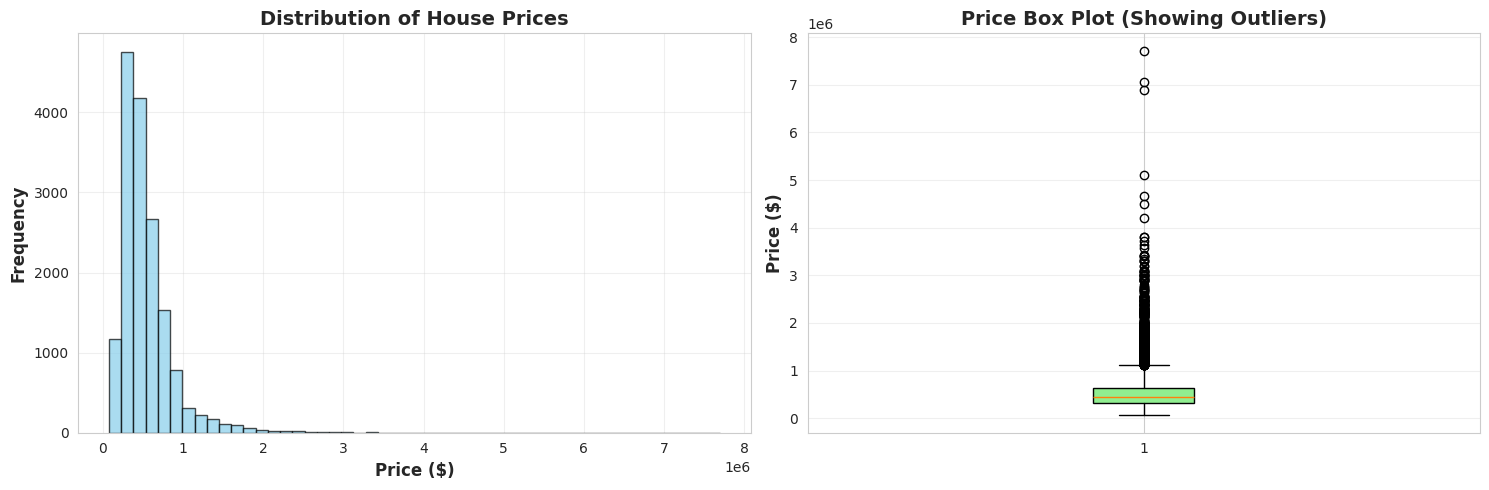

Observation: We can see the distribution and identify outliers


In [29]:
# Plotting price distribution using histogram and box plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Creating histogram
axes[0].hist(train_df['price'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price ($)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of House Prices', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Creating box plot
box_plot = axes[1].boxplot(train_df['price'], vert=True, patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightgreen')
axes[1].set_ylabel('Price ($)', fontsize=12, fontweight='bold')
axes[1].set_title('Price Box Plot (Showing Outliers)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Observation: We can see the distribution and identify outliers")

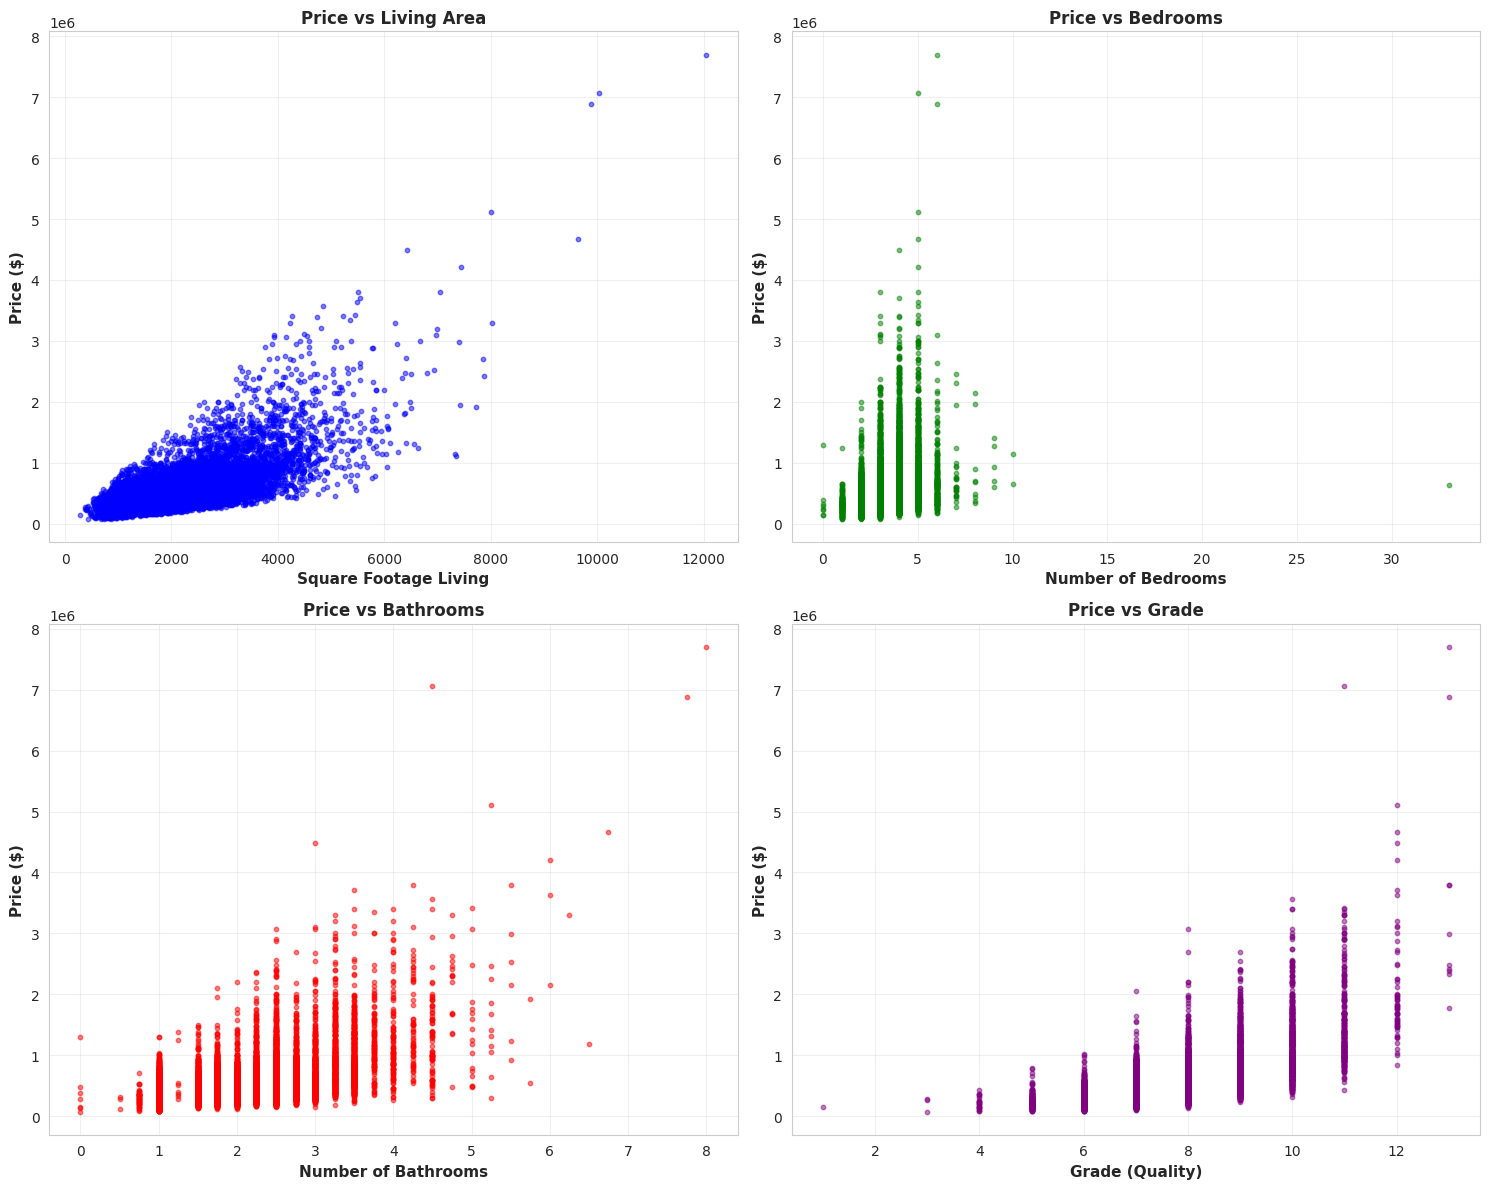

We can see positive correlations - as features increase, price tends to increase


In [31]:
# Plotting price vs important features
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Price vs Square Footage Living
axes[0, 0].scatter(train_df['sqft_living'], train_df['price'], alpha=0.5, color='blue', s=10)
axes[0, 0].set_xlabel('Square Footage Living', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Price ($)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Price vs Living Area', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Price vs Bedrooms
axes[0, 1].scatter(train_df['bedrooms'], train_df['price'], alpha=0.5, color='green', s=10)
axes[0, 1].set_xlabel('Number of Bedrooms', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Price ($)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Price vs Bedrooms', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Price vs Bathrooms
axes[1, 0].scatter(train_df['bathrooms'], train_df['price'], alpha=0.5, color='red', s=10)
axes[1, 0].set_xlabel('Number of Bathrooms', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Price ($)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Price vs Bathrooms', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Price vs Grade
axes[1, 1].scatter(train_df['grade'], train_df['price'], alpha=0.5, color='purple', s=10)
axes[1, 1].set_xlabel('Grade (Quality)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Price ($)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Price vs Grade', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("We can see positive correlations - as features increase, price tends to increase")

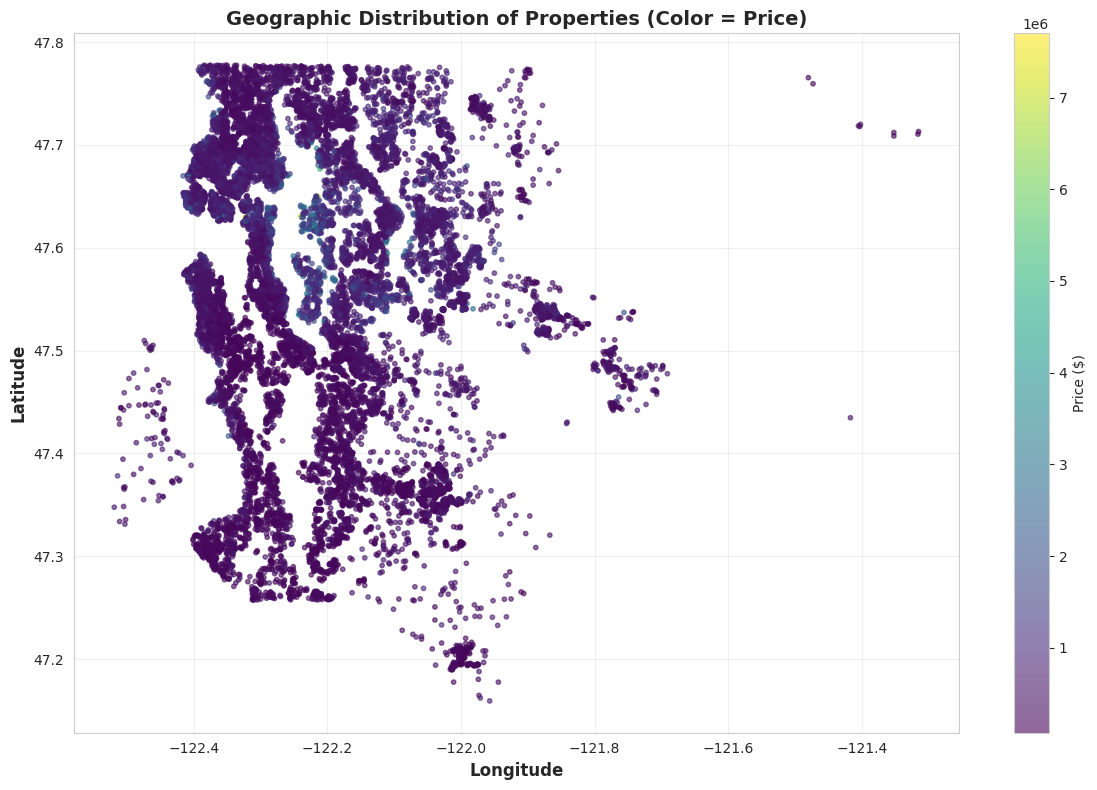

Observation: We can see property locations and how prices vary by area
Expensive properties (yellow) seem to cluster in certain areas!


In [32]:
# Plotting geographic distribution of properties
plt.figure(figsize=(12, 8))

# Creating scatter plot with price as color
scatter = plt.scatter(train_df['long'], train_df['lat'],
                     c=train_df['price'], cmap='viridis',
                     alpha=0.6, s=10)

plt.colorbar(scatter, label='Price ($)')
plt.xlabel('Longitude', fontsize=12, fontweight='bold')
plt.ylabel('Latitude', fontsize=12, fontweight='bold')
plt.title('Geographic Distribution of Properties (Color = Price)',
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Observation: We can see property locations and how prices vary by area")
print("Expensive properties (yellow) seem to cluster in certain areas!")

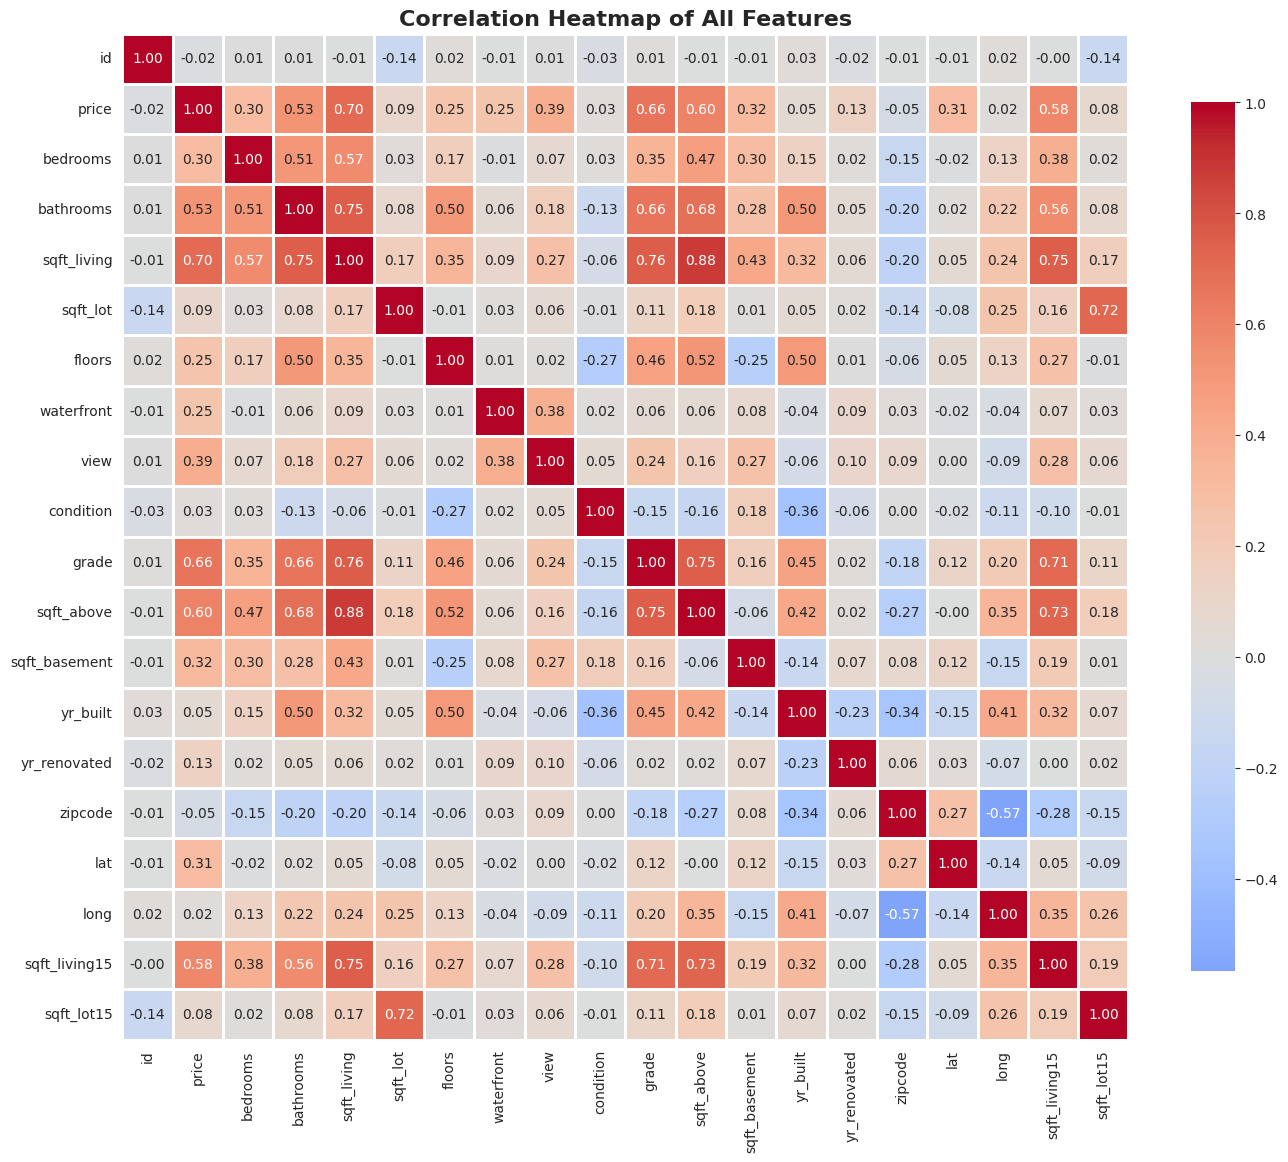

Red = Positive correlation | Blue = Negative correlation


In [33]:
# Calculating and visualizing correlation between features
# Selecting only numerical columns
numerical_cols = train_df.select_dtypes(include=[np.number]).columns

# Computing correlation matrix
corr_matrix = train_df[numerical_cols].corr()

# Creating heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of All Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Red = Positive correlation | Blue = Negative correlation")

In [34]:
# Finding features most correlated with price
price_corr = corr_matrix['price'].sort_values(ascending=False)

print("="*60)
print("🎯 TOP FEATURES CORRELATED WITH PRICE")
print("="*60)
print(price_corr.to_string())
print("="*60)
print("\n💡 Higher absolute values mean stronger relationship with price")

🎯 TOP FEATURES CORRELATED WITH PRICE
price            1.000000
sqft_living      0.700933
grade            0.664266
sqft_above       0.602648
sqft_living15    0.581781
bathrooms        0.525487
view             0.390534
sqft_basement    0.320301
lat              0.310008
bedrooms         0.304454
floors           0.251428
waterfront       0.245221
yr_renovated     0.133075
sqft_lot         0.088526
sqft_lot15       0.076060
yr_built         0.048307
condition        0.031333
long             0.024279
id              -0.020260
zipcode         -0.054517

💡 Higher absolute values mean stronger relationship with price


## Data Cleaning and Preparation
Performing data cleaning operations including:
- Removing duplicate entries
- Handling missing values in essential columns
- Removing invalid data points

In [75]:
# Creating a copy of training data for cleaning
cleaned_train = train_df.copy()

print("=" * 70)
print("DATA CLEANING PROCESS - TRAINING DATA")
print("=" * 70)

# Checking for duplicate property IDs
duplicate_count = cleaned_train['id'].duplicated().sum()
print(f"Duplicate property IDs found: {duplicate_count}")

if duplicate_count > 0:
    # Removing duplicates, keeping first occurrence
    cleaned_train = cleaned_train.drop_duplicates(subset=['id'], keep='first')
    print(f"Action: Removed {duplicate_count} duplicate entries")

# Checking for missing essential columns
essential_columns = ['id', 'price', 'lat', 'long']
missing_essential = cleaned_train[essential_columns].isnull().any(axis=1).sum()
print(f"\nRows with missing essential data: {missing_essential}")

if missing_essential > 0:
    # Removing rows with missing essential data
    cleaned_train = cleaned_train.dropna(subset=essential_columns)
    print(f"Action: Removed {missing_essential} rows with missing essential data")

print(f"\nOriginal size: {len(train_df)} properties")
print(f"Cleaned size: {len(cleaned_train)} properties")
print(f"Rows removed: {len(train_df) - len(cleaned_train)}")
print("=" * 70)

DATA CLEANING PROCESS - TRAINING DATA
Duplicate property IDs found: 99
Action: Removed 99 duplicate entries

Rows with missing essential data: 0

Original size: 16209 properties
Cleaned size: 16110 properties
Rows removed: 99


In [76]:
# Saving cleaned training data
cleaned_train_path = f'{data_path}/cleaned_train.csv'
cleaned_train.to_csv(cleaned_train_path, index=False)

print("=" * 70)
print("CLEANED TRAINING DATA SAVED")
print("=" * 70)
print(f"File location: {cleaned_train_path}")
print(f"Properties saved: {len(cleaned_train)}")
print(f"Features saved: {len(cleaned_train.columns)}")
print("=" * 70)

CLEANED TRAINING DATA SAVED
File location: /content/drive/My Drive/Property_Valuation_Project/data/cleaned_train.csv
Properties saved: 16110
Features saved: 21


#PART 3: FEATURE ENGINEERING (TRAINING DATA)
Creating new features that may improve model performance:
- Price per square foot
- Total rooms
- Bathroom to bedroom ratio
- Property age
- Renovation status
- Log transformations for skewed features

In [77]:
# Creating engineered features for training data
print("=" * 70)
print("FEATURE ENGINEERING - TRAINING DATA")
print("=" * 70)

# Feature 1: Price per square foot
cleaned_train['price_per_sqft'] = cleaned_train['price'] / cleaned_train['sqft_living']
print("Created: price_per_sqft")

# Feature 2: Total rooms
cleaned_train['total_rooms'] = cleaned_train['bedrooms'] + cleaned_train['bathrooms']
print("Created: total_rooms")

# Feature 3: Bathroom to bedroom ratio
cleaned_train['bath_bed_ratio'] = cleaned_train['bathrooms'] / (cleaned_train['bedrooms'] + 1)
print("Created: bath_bed_ratio")

# Feature 4: Property age (assuming current year is 2024)
current_year = 2024
cleaned_train['property_age'] = current_year - cleaned_train['yr_built']
print("Created: property_age")

# Feature 5: Years since renovation
cleaned_train['years_since_renovation'] = current_year - cleaned_train['yr_renovated']
# For properties never renovated (yr_renovated = 0), set to property age
cleaned_train.loc[cleaned_train['yr_renovated'] == 0, 'years_since_renovation'] = cleaned_train['property_age']
print("Created: years_since_renovation")

# Feature 6: Has been renovated (binary)
cleaned_train['has_been_renovated'] = (cleaned_train['yr_renovated'] > 0).astype(int)
print("Created: has_been_renovated")

# Feature 7: Above ground to total living ratio
cleaned_train['above_to_living_ratio'] = cleaned_train['sqft_above'] / cleaned_train['sqft_living']
print("Created: above_to_living_ratio")

# Feature 8: Living space compared to neighbors
cleaned_train['living_vs_neighbors'] = cleaned_train['sqft_living'] / (cleaned_train['sqft_living15'] + 1)
print("Created: living_vs_neighbors")

# Feature 9: Lot size compared to neighbors
cleaned_train['lot_vs_neighbors'] = cleaned_train['sqft_lot'] / (cleaned_train['sqft_lot15'] + 1)
print("Created: lot_vs_neighbors")

print("=" * 70)
print(f"Total new features created: 9")
print(f"Total features now: {len(cleaned_train.columns)}")
print("=" * 70)

FEATURE ENGINEERING - TRAINING DATA
Created: price_per_sqft
Created: total_rooms
Created: bath_bed_ratio
Created: property_age
Created: years_since_renovation
Created: has_been_renovated
Created: above_to_living_ratio
Created: living_vs_neighbors
Created: lot_vs_neighbors
Total new features created: 9
Total features now: 30


In [78]:
# Applying log transformations to skewed features
print("=" * 70)
print("LOG TRANSFORMATIONS FOR SKEWED FEATURES")
print("=" * 70)

# Identifying skewed features (common ones in real estate data)
skewed_features = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for feature in skewed_features:
    if feature in cleaned_train.columns:
        # Adding small constant to handle zeros
        cleaned_train[f'log_{feature}'] = np.log1p(cleaned_train[feature])
        print(f"Created: log_{feature}")

print("=" * 70)
print(f"Log-transformed features created: {len(skewed_features)}")
print("=" * 70)

LOG TRANSFORMATIONS FOR SKEWED FEATURES
Created: log_sqft_living
Created: log_sqft_lot
Created: log_sqft_above
Created: log_sqft_basement
Log-transformed features created: 4


In [79]:
# Displaying sample of engineered features
print("Sample of engineered features:")
engineered_cols = ['price_per_sqft', 'total_rooms', 'bath_bed_ratio', 'property_age',
                   'has_been_renovated', 'living_vs_neighbors']
cleaned_train[engineered_cols].head(10)

Sample of engineered features:


price_per_sqft  total_rooms  bath_bed_ratio  property_age  \
0      148.421547         6.25        0.450000            63   
1      153.125000         5.50        0.625000            32   
2      116.279070         6.50        0.500000            30   
3      284.273387         4.25        0.750000            15   
4      181.250000         5.00        0.500000            30   
5      277.884615         7.50        0.700000            21   
6      283.014151         3.00        0.333333            73   
7      413.145540         5.00        0.500000            35   
8      163.551402         4.00        0.250000            57   
9      320.641283         5.25        0.562500            17   

   has_been_renovated  living_vs_neighbors  
0                   0             1.089705  
1                   0             0.929692  
2                   0             0.919294  
3                   0             0.999194  
4                   0             0.804525  
5                   0             1.299350  
6                   0             0.572663  
7                   0             0.744495  
8                   0             0.809992  
9                   0             0.998999

#PART 4: SATELLITE IMAGE COLLECTION (TRAINING)
Using Mapbox API to download satellite imagery for all training properties.
These images capture environmental context that tabular data cannot represent:
- Vegetation and green spaces
- Water proximity
- Road networks
- Building density
- Neighborhood characteristics

In [80]:
# Downloading data_fetcher.py from GitHub repository
import requests

github_url = 'https://raw.githubusercontent.com/Rahul1227/Satellite-Imagery-Based-Property-Valuation-/main/data_fetcher.py'

print("=" * 70)
print("DOWNLOADING DATA FETCHER SCRIPT")
print("=" * 70)
print(f"Source: {github_url}")

response = requests.get(github_url)

if response.status_code == 200:
    # Saving the script
    with open('data_fetcher.py', 'w') as f:
        f.write(response.text)
    print("Status: Successfully downloaded")
    print("File saved as: data_fetcher.py")
else:
    print(f"Error: Failed to download (HTTP {response.status_code})")

print("=" * 70)

DOWNLOADING DATA FETCHER SCRIPT
Source: https://raw.githubusercontent.com/Rahul1227/Satellite-Imagery-Based-Property-Valuation-/main/data_fetcher.py
Status: Successfully downloaded
File saved as: data_fetcher.py


In [81]:
# Loading Mapbox API token from Colab Secrets
from google.colab import userdata

try:
    MAPBOX_API_TOKEN = userdata.get('MAPBOX_TOKEN')
    print("=" * 70)
    print("API TOKEN LOADED SUCCESSFULLY")
    print("=" * 70)
    print(f"Token length: {len(MAPBOX_API_TOKEN)} characters")
    print(f"Token preview: {MAPBOX_API_TOKEN[:15]}...{MAPBOX_API_TOKEN[-10:]}")
    print("=" * 70)
except Exception as e:
    print("=" * 70)
    print("ERROR: Could not load API token from Colab Secrets")
    print("=" * 70)
    print("Please add your Mapbox token to Colab Secrets:")
    print("1. Click the key icon in the left sidebar")
    print("2. Add new secret: Name='MAPBOX_TOKEN', Value='your_token_here'")
    print(f"Error details: {str(e)}")
    print("=" * 70)

API TOKEN LOADED SUCCESSFULLY
Token length: 98 characters
Token preview: pk.eyJ1IjoiYWF0...73VX7fHtig


In [82]:
# Creating folder structure for images
train_images_folder = f'{images_path}/train'
test_images_folder = f'{images_path}/test'

# Creating directories
os.makedirs(train_images_folder, exist_ok=True)
os.makedirs(test_images_folder, exist_ok=True)

print("=" * 70)
print("IMAGE FOLDER STRUCTURE CREATED")
print("=" * 70)
print(f"Training images folder: {train_images_folder}")
print(f"Test images folder: {test_images_folder}")
print("=" * 70)

IMAGE FOLDER STRUCTURE CREATED
Training images folder: /content/drive/My Drive/Property_Valuation_Project/images/train
Test images folder: /content/drive/My Drive/Property_Valuation_Project/images/test


In [83]:
# Adding current directory to Python path
import sys
sys.path.insert(0, '/content')

# Importing the SatelliteImageFetcher class
from data_fetcher import SatelliteImageFetcher

# Initializing the fetcher
fetcher = SatelliteImageFetcher(
    api_token=MAPBOX_API_TOKEN,
    image_size='256x256',
    zoom_level=18
)

print("Image fetcher initialized successfully")

Satellite Image Fetcher initialized successfully
Configuration - Image size: 256x256, Zoom level: 18
Image fetcher initialized successfully


In [84]:
# Testing with a small sample before full download
test_sample = cleaned_train.head(3)
test_folder = '/content/test_images_sample'
os.makedirs(test_folder, exist_ok=True)

print("=" * 70)
print("TESTING IMAGE DOWNLOAD WITH 3 SAMPLES")
print("=" * 70)

# Downloading test images
for idx, row in test_sample.iterrows():
    prop_id = row['id']
    lat = row['lat']
    lon = row['long']
    test_path = f"{test_folder}/property_{prop_id}.jpg"

    success = fetcher.download_single_image(lat, lon, prop_id, test_path)
    if success:
        print(f"Property {prop_id}: Downloaded successfully")
    else:
        print(f"Property {prop_id}: Download failed")

    time.sleep(0.3)

print("=" * 70)
print("Test complete. API is working correctly.")
print("=" * 70)

TESTING IMAGE DOWNLOAD WITH 3 SAMPLES
Property 9117000170: Downloaded successfully
Property 6700390210: Downloaded successfully
Property 7212660540: Downloaded successfully
Test complete. API is working correctly.


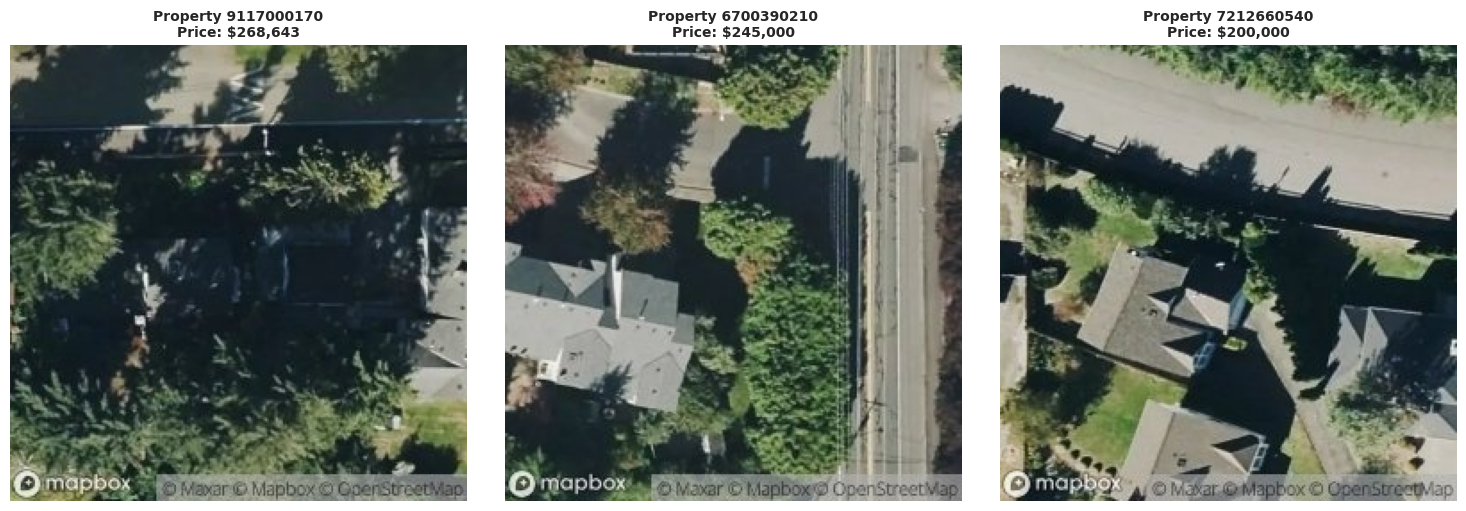

The setup is working correctly


In [86]:
# Visualizing downloaded test images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (_, row) in enumerate(test_sample.iterrows()):
    img_path = f"{test_folder}/property_{row['id']}.jpg"

    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f"Property {row['id']}\nPrice: ${row['price']:,.0f}",
                           fontsize=10, fontweight='bold')
        axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, 'Image Not Found',
                      ha='center', va='center', fontsize=12)
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("The setup is working correctly")

##Batch Download of Training Images

Downloading all training images in batches to ensure:
- Progress is saved incrementally
- Already downloaded images are skipped
- Download can be resumed if interrupted

In [87]:
# Configuring batch download parameters
batch_size = 1000
total_properties = len(cleaned_train)
total_batches = (total_properties + batch_size - 1) // batch_size

print("=" * 70)
print("BATCH DOWNLOAD CONFIGURATION")
print("=" * 70)
print(f"Total properties: {total_properties}")
print(f"Batch size: {batch_size} images per batch")
print(f"Total batches: {total_batches}")
print(f"Estimated time per batch: {(batch_size * 0.25 / 60):.1f} minutes")
print(f"Total estimated time: {(total_properties * 0.25 / 60):.1f} minutes")
print("=" * 70)
print("\nNote: Already downloaded images will be skipped automatically")

BATCH DOWNLOAD CONFIGURATION
Total properties: 16110
Batch size: 1000 images per batch
Total batches: 17
Estimated time per batch: 4.2 minutes
Total estimated time: 67.1 minutes

Note: Already downloaded images will be skipped automatically


In [88]:
# Downloading all training images in batches
from IPython.display import clear_output

# Creating tracking dictionary
batch_results = {
    'batch_number': [],
    'start_index': [],
    'end_index': [],
    'successful': [],
    'failed': [],
    'time_taken': []
}

print("=" * 70)
print("STARTING BATCH DOWNLOAD PROCESS")
print("=" * 70)
print("Progress will be saved after each batch")
print("Already downloaded images will be skipped")
print("=" * 70)

# Looping through all batches
for batch_num in range(1, total_batches + 1):
    # Calculating batch indices
    start_idx = (batch_num - 1) * batch_size
    end_idx = min(start_idx + batch_size, total_properties)

    # Getting batch data
    batch_data = cleaned_train.iloc[start_idx:end_idx]

    print(f"\n{'=' * 70}")
    print(f"BATCH {batch_num}/{total_batches} - Processing images {start_idx + 1} to {end_idx}")
    print("=" * 70)

    # Tracking batch progress
    batch_start_time = time.time()
    successful_count = 0
    failed_count = 0

    for idx, (_, row) in enumerate(batch_data.iterrows(), 1):
        prop_id = row['id']
        lat = row['lat']
        lon = row['long']

        # Constructing file path
        image_path = os.path.join(train_images_folder, f'property_{prop_id}.jpg')

        # Checking if image already exists
        if os.path.exists(image_path):
            successful_count += 1
        else:
            # Downloading the image
            download_result = fetcher.download_single_image(lat, lon, prop_id, image_path)
            if download_result:
                successful_count += 1
            else:
                failed_count += 1

            # Adding delay to respect API rate limits
            time.sleep(0.2)

        # Updating progress display every 10 images
        if idx % 10 == 0 or idx == len(batch_data):
            progress_pct = (idx / len(batch_data)) * 100
            bar_length = 40
            filled_length = int(bar_length * idx / len(batch_data))
            progress_bar = '█' * filled_length + '░' * (bar_length - filled_length)

            clear_output(wait=True)
            print(f"\n{'=' * 70}")
            print(f"BATCH {batch_num}/{total_batches} - Processing images {start_idx + 1} to {end_idx}")
            print("=" * 70)
            print(f"\nProgress: [{progress_bar}] {progress_pct:.1f}%")
            print(f"Images: {idx}/{len(batch_data)}")
            print(f"Successful: {successful_count} | Failed: {failed_count}")

    batch_elapsed_time = time.time() - batch_start_time

    # Storing batch statistics
    batch_results['batch_number'].append(batch_num)
    batch_results['start_index'].append(start_idx)
    batch_results['end_index'].append(end_idx)
    batch_results['successful'].append(successful_count)
    batch_results['failed'].append(failed_count)
    batch_results['time_taken'].append(batch_elapsed_time)

    print(f"\nBatch {batch_num} completed: {successful_count}/{len(batch_data)} successful")
    print(f"Time taken: {batch_elapsed_time/60:.2f} minutes")

    # Displaying checkpoint every 5 batches
    if batch_num % 5 == 0:
        total_downloaded = sum(batch_results['successful'])
        total_failed = sum(batch_results['failed'])
        images_processed = batch_results['end_index'][-1]

        print(f"\n{'=' * 70}")
        print("CHECKPOINT - PROGRESS UPDATE")
        print("=" * 70)
        print(f"Batches completed: {batch_num}/{total_batches}")
        print(f"Images processed: {images_processed}/{total_properties}")
        print(f"Successfully downloaded: {total_downloaded}")
        print(f"Failed downloads: {total_failed}")
        print(f"Success rate: {(total_downloaded/images_processed)*100:.2f}%")
        print("=" * 70)

# Final summary
print(f"\n{'=' * 70}")
print("ALL BATCHES COMPLETED")
print("=" * 70)

total_successful = sum(batch_results['successful'])
total_failed = sum(batch_results['failed'])
total_time = sum(batch_results['time_taken'])

print("\nFINAL DOWNLOAD SUMMARY")
print("=" * 70)
print(f"Total images processed: {total_properties}")
print(f"Successfully downloaded: {total_successful}")
print(f"Failed downloads: {total_failed}")
print(f"Overall success rate: {(total_successful/total_properties)*100:.2f}%")
print(f"Total time taken: {total_time/60:.2f} minutes")
print(f"Average time per batch: {(total_time/total_batches)/60:.2f} minutes")
print("=" * 70)


BATCH 17/17 - Processing images 16001 to 16110

Progress: [████████████████████████████████████████] 100.0%
Images: 110/110
Successful: 110 | Failed: 0

Batch 17 completed: 110/110 successful
Time taken: 1.29 minutes

ALL BATCHES COMPLETED

FINAL DOWNLOAD SUMMARY
Total images processed: 16110
Successfully downloaded: 16110
Failed downloads: 0
Overall success rate: 100.00%
Total time taken: 108.43 minutes
Average time per batch: 6.38 minutes


In [89]:
# Creating image mapping for training data
print("=" * 70)
print("CREATING IMAGE MAPPING FILE FOR TRAINING DATA")
print("=" * 70)

train_mapping = fetcher.create_image_mapping(
    data_df=cleaned_train,
    images_folder=train_images_folder,
    output_csv_path=f'{data_path}/train_image_mapping.csv'
)

print("\nSample of training image mapping:")
train_mapping.head(10)

CREATING IMAGE MAPPING FILE FOR TRAINING DATA
Creating image mapping file...
Image mapping created successfully
Images available: 16110 out of 16110
Mapping saved to: /content/drive/My Drive/Property_Valuation_Project/data/train_image_mapping.csv

Sample of training image mapping:


id      lat     long  \
0  9117000170  47.4362 -122.187   
1  6700390210  47.4034 -122.187   
2  7212660540  47.2704 -122.313   
3  8562780200  47.5321 -122.073   
4  7760400350  47.3715 -122.074   
5   464001025  47.6948 -122.395   
6  3432500486  47.7463 -122.315   
7  1126059095  47.7489 -122.123   
8  3876500290  47.3377 -122.291   
9  1865400075  47.6983 -122.367   

                                          image_path  image_exists  
0  /content/drive/My Drive/Property_Valuation_Pro...          True  
1  /content/drive/My Drive/Property_Valuation_Pro...          True  
2  /content/drive/My Drive/Property_Valuation_Pro...          True  
3  /content/drive/My Drive/Property_Valuation_Pro...          True  
4  /content/drive/My Drive/Property_Valuation_Pro...          True  
5  /content/drive/My Drive/Property_Valuation_Pro...          True  
6  /content/drive/My Drive/Property_Valuation_Pro...          True  
7  /content/drive/My Drive/Property_Valuation_Pro...          True  
8  /content/drive/My Drive/Property_Valuation_Pro...          True  
9  /content/drive/My Drive/Property_Valuation_Pro...          True

In [90]:
# Verifying downloaded training images
print("=" * 70)
print("VERIFYING TRAINING IMAGES")
print("=" * 70)

verification = fetcher.verify_images(
    images_folder=train_images_folder,
    sample_size=50
)

print(f"\n{'=' * 70}")
print("VERIFICATION RESULTS")
print("=" * 70)
print(f"Images checked: {verification['total_checked']}")
print(f"Valid images: {verification['valid_images']}")
print(f"Corrupted images: {verification['corrupted_images']}")

if verification['corrupted_images'] == 0:
    print("\nAll checked images are valid")
else:
    print(f"\nWarning: {verification['corrupted_images']} corrupted images detected")

print("=" * 70)

VERIFYING TRAINING IMAGES
Verifying downloaded images...
Verification complete: 50 valid, 0 corrupted

VERIFICATION RESULTS
Images checked: 50
Valid images: 50
Corrupted images: 0

All checked images are valid


In [91]:
# Verifying images
print("="*60)
print("VERIFYING DOWNLOADED IMAGES")
print("="*60)

verification_results = fetcher.verify_images(
    images_folder=train_images_folder,
    sample_size=50
)

print("\n" + "="*60)
print("VERIFICATION SUMMARY")
print("="*60)
print(f"Images checked: {verification_results['total_checked']}")
print(f"Valid images: {verification_results['valid_images']}")
print(f"Corrupted images: {verification_results['corrupted_images']}")
if verification_results['corrupted_images'] > 0:
    print("\nWarning: Some images may be corrupted")
else:
    print("\nAll checked images are valid!")
print("="*60)

VERIFYING DOWNLOADED IMAGES
Verifying downloaded images...
Verification complete: 50 valid, 0 corrupted

VERIFICATION SUMMARY
Images checked: 50
Valid images: 50
Corrupted images: 0

All checked images are valid!


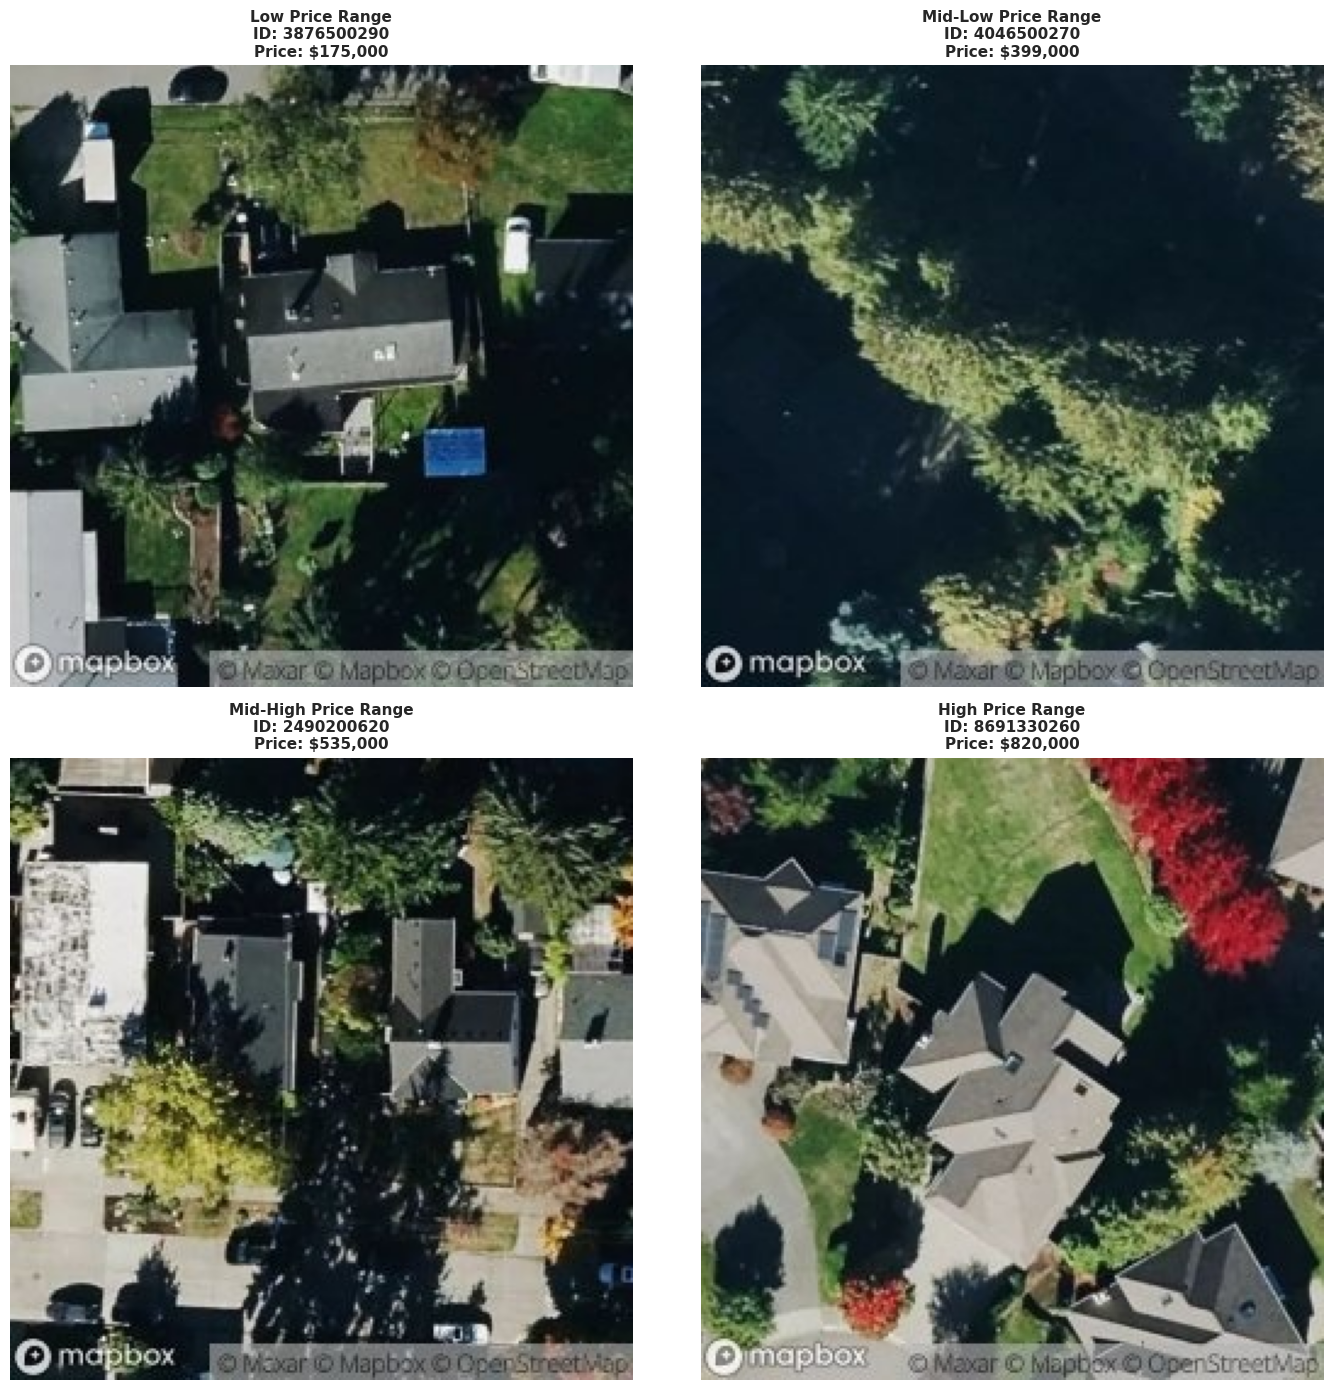

Observation: Visual differences in vegetation, density, and development across price ranges


In [92]:
# Visualizing properties from different price ranges
price_quartiles = cleaned_train['price'].quantile([0.25, 0.5, 0.75]).values

# Selecting one property from each price range
low_price_prop = cleaned_train[cleaned_train['price'] < price_quartiles[0]].iloc[5]
mid_low_prop = cleaned_train[(cleaned_train['price'] >= price_quartiles[0]) &
                             (cleaned_train['price'] < price_quartiles[1])].iloc[5]
mid_high_prop = cleaned_train[(cleaned_train['price'] >= price_quartiles[1]) &
                              (cleaned_train['price'] < price_quartiles[2])].iloc[5]
high_price_prop = cleaned_train[cleaned_train['price'] >= price_quartiles[2]].iloc[5]

# Creating visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

properties = [low_price_prop, mid_low_prop, mid_high_prop, high_price_prop]
labels = ['Low Price Range', 'Mid-Low Price Range', 'Mid-High Price Range', 'High Price Range']

for idx, (prop, label) in enumerate(zip(properties, labels)):
    img_path = f"{train_images_folder}/property_{prop['id']}.jpg"

    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        title_text = f"{label}\nID: {prop['id']}\nPrice: ${prop['price']:,.0f}"
        axes[idx].set_title(title_text, fontsize=11, fontweight='bold')
    else:
        axes[idx].text(0.5, 0.5, 'Image Not Available',
                      ha='center', va='center', fontsize=12)

    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("Observation: Visual differences in vegetation, density, and development across price ranges")

#PART 5: TEST DATA PROCESSING
Applying the same cleaning and feature engineering steps to test data.
Important: We do NOT remove any rows from test data because we need predictions for all properties.

In [93]:
# Creating copy of test data for cleaning
cleaned_test = test_df.copy()

print("=" * 70)
print("DATA CLEANING PROCESS - TEST DATA")
print("=" * 70)
print(f"Original test set size: {len(test_df)} properties")

# Checking for duplicates in test data
test_duplicates = cleaned_test['id'].duplicated().sum()
print(f"Duplicate IDs in test data: {test_duplicates}")

if test_duplicates > 0:
    # Removing duplicates
    cleaned_test = cleaned_test.drop_duplicates(subset=['id'], keep='first')
    print(f"Action: Removed {test_duplicates} duplicates")

# Checking for missing essential coordinates
# Note: We do NOT remove rows from test data, even if lat/long are missing
# We will still make predictions using tabular data only
missing_coords = cleaned_test[['lat', 'long']].isnull().any(axis=1).sum()
print(f"\nProperties with missing coordinates: {missing_coords}")
if missing_coords > 0:
    print("Note: These properties will get predictions using tabular data only")

print(f"\nFinal test set size: {len(cleaned_test)} properties")
print("=" * 70)

DATA CLEANING PROCESS - TEST DATA
Original test set size: 5404 properties
Duplicate IDs in test data: 8
Action: Removed 8 duplicates

Properties with missing coordinates: 0

Final test set size: 5396 properties


In [94]:
# Applying same feature engineering to test data
print("=" * 70)
print("FEATURE ENGINEERING - TEST DATA")
print("=" * 70)

# Creating same features as training data
cleaned_test['price_per_sqft'] = cleaned_test['sqft_living']  # Placeholder since we don't have test prices
cleaned_test['total_rooms'] = cleaned_test['bedrooms'] + cleaned_test['bathrooms']
cleaned_test['bath_bed_ratio'] = cleaned_test['bathrooms'] / (cleaned_test['bedrooms'] + 1)
cleaned_test['property_age'] = current_year - cleaned_test['yr_built']
cleaned_test['years_since_renovation'] = current_year - cleaned_test['yr_renovated']
cleaned_test.loc[cleaned_test['yr_renovated'] == 0, 'years_since_renovation'] = cleaned_test['property_age']
cleaned_test['has_been_renovated'] = (cleaned_test['yr_renovated'] > 0).astype(int)
cleaned_test['above_to_living_ratio'] = cleaned_test['sqft_above'] / cleaned_test['sqft_living']
cleaned_test['living_vs_neighbors'] = cleaned_test['sqft_living'] / (cleaned_test['sqft_living15'] + 1)
cleaned_test['lot_vs_neighbors'] = cleaned_test['sqft_lot'] / (cleaned_test['sqft_lot15'] + 1)

# Applying log transformations
for feature in skewed_features:
    if feature in cleaned_test.columns:
        cleaned_test[f'log_{feature}'] = np.log1p(cleaned_test[feature])

print("Same features created for test data as training data")
print(f"Total features in test data: {len(cleaned_test.columns)}")
print("=" * 70)

FEATURE ENGINEERING - TEST DATA
Same features created for test data as training data
Total features in test data: 33


In [95]:
# Handling missing values in test data using training data statistics
print("=" * 70)
print("HANDLING MISSING VALUES IN TEST DATA")
print("=" * 70)

# Getting numerical columns
numerical_cols_test = cleaned_test.select_dtypes(include=[np.number]).columns

# Filling missing values with median from training data
for col in numerical_cols_test:
    if cleaned_test[col].isnull().sum() > 0:
        # Using training data median for filling
        fill_value = cleaned_train[col].median() if col in cleaned_train.columns else cleaned_test[col].median()
        cleaned_test[col].fillna(fill_value, inplace=True)
        print(f"Filled missing values in {col} with median: {fill_value:.2f}")

print("=" * 70)
print("All missing values in test data handled")
print("=" * 70)

HANDLING MISSING VALUES IN TEST DATA
All missing values in test data handled


In [96]:
# Saving cleaned test data
cleaned_test_path = f'{data_path}/cleaned_test.csv'
cleaned_test.to_csv(cleaned_test_path, index=False)

print("=" * 70)
print("CLEANED TEST DATA SAVED")
print("=" * 70)
print(f"File location: {cleaned_test_path}")
print(f"Properties saved: {len(cleaned_test)}")
print(f"Features saved: {len(cleaned_test.columns)}")
print("=" * 70)

CLEANED TEST DATA SAVED
File location: /content/drive/My Drive/Property_Valuation_Project/data/cleaned_test.csv
Properties saved: 5396
Features saved: 33


##Downloading Satellite Images for Test Data

Downloading satellite images for test properties using the same API setup.

In [108]:
# Filtering test properties with valid coordinates
test_with_coords = cleaned_test[cleaned_test[['lat', 'long']].notna().all(axis=1)].copy()

print("=" * 70)
print("TEST IMAGE DOWNLOAD PREPARATION")
print("=" * 70)
print(f"Total test properties: {len(cleaned_test)}")
print(f"Properties with valid coordinates: {len(test_with_coords)}")
print(f"Properties without coordinates: {len(cleaned_test) - len(test_with_coords)}")
print("=" * 70)

if len(test_with_coords) > 0:
    # Configuring batch parameters for test data
    test_batch_size = 1000
    total_test_properties = len(test_with_coords)
    total_test_batches = (total_test_properties + test_batch_size - 1) // test_batch_size

    print("\nNote: Already downloaded images will be skipped automatically")
else:
    print("\nNo test properties with valid coordinates for image download")

TEST IMAGE DOWNLOAD PREPARATION
Total test properties: 5396
Properties with valid coordinates: 5396
Properties without coordinates: 0

Note: Already downloaded images will be skipped automatically


In [98]:
# Downloading test images in batches
if len(test_with_coords) > 0:

    # Creating tracking dictionary for test batches
    test_batch_results = {
        'batch_number': [],
        'start_index': [],
        'end_index': [],
        'successful': [],
        'failed': [],
        'time_taken': []
    }

    print("=" * 70)
    print("STARTING TEST IMAGES BATCH DOWNLOAD")
    print("=" * 70)
    print("Progress will be saved after each batch")
    print("Already downloaded images will be skipped")
    print("=" * 70)

    # Looping through all test batches
    for batch_num in range(1, total_test_batches + 1):
        # Calculating batch indices
        start_idx = (batch_num - 1) * test_batch_size
        end_idx = min(start_idx + test_batch_size, total_test_properties)

        # Getting batch data
        test_batch_data = test_with_coords.iloc[start_idx:end_idx]

        print(f"\n{'=' * 70}")
        print(f"TEST BATCH {batch_num}/{total_test_batches} - Processing images {start_idx + 1} to {end_idx}")
        print("=" * 70)

        # Tracking batch progress
        batch_start_time = time.time()
        successful_count = 0
        failed_count = 0

        for idx, (_, row) in enumerate(test_batch_data.iterrows(), 1):
            prop_id = row['id']
            lat = row['lat']
            lon = row['long']

            # Constructing file path
            image_path = os.path.join(test_images_folder, f'property_{prop_id}.jpg')

            # Checking if image already exists
            if os.path.exists(image_path):
                successful_count += 1
            else:
                # Downloading the image
                download_result = fetcher.download_single_image(lat, lon, prop_id, image_path)
                if download_result:
                    successful_count += 1
                else:
                    failed_count += 1

                # Adding delay to respect API rate limits
                time.sleep(0.2)

            # Updating progress display every 10 images
            if idx % 10 == 0 or idx == len(test_batch_data):
                progress_pct = (idx / len(test_batch_data)) * 100
                bar_length = 40
                filled_length = int(bar_length * idx / len(test_batch_data))
                progress_bar = '█' * filled_length + '░' * (bar_length - filled_length)

                clear_output(wait=True)
                print(f"\n{'=' * 70}")
                print(f"TEST BATCH {batch_num}/{total_test_batches} - Processing images {start_idx + 1} to {end_idx}")
                print("=" * 70)
                print(f"\nProgress: [{progress_bar}] {progress_pct:.1f}%")
                print(f"Images: {idx}/{len(test_batch_data)}")
                print(f"Successful: {successful_count} | Failed: {failed_count}")

        batch_elapsed_time = time.time() - batch_start_time

        # Storing batch statistics
        test_batch_results['batch_number'].append(batch_num)
        test_batch_results['start_index'].append(start_idx)
        test_batch_results['end_index'].append(end_idx)
        test_batch_results['successful'].append(successful_count)
        test_batch_results['failed'].append(failed_count)
        test_batch_results['time_taken'].append(batch_elapsed_time)

        print(f"\nTest Batch {batch_num} completed: {successful_count}/{len(test_batch_data)} successful")
        print(f"Time taken: {batch_elapsed_time/60:.2f} minutes")

        # Displaying checkpoint every 5 batches
        if batch_num % 5 == 0 or batch_num == total_test_batches:
            total_downloaded = sum(test_batch_results['successful'])
            total_failed = sum(test_batch_results['failed'])
            images_processed = test_batch_results['end_index'][-1]

            print(f"\n{'=' * 70}")
            print("TEST IMAGES CHECKPOINT - PROGRESS UPDATE")
            print("=" * 70)
            print(f"Batches completed: {batch_num}/{total_test_batches}")
            print(f"Images processed: {images_processed}/{total_test_properties}")
            print(f"Successfully downloaded: {total_downloaded}")
            print(f"Failed downloads: {total_failed}")
            print(f"Success rate: {(total_downloaded/images_processed)*100:.2f}%")
            print("=" * 70)

    # Final summary for test images
    print(f"\n{'=' * 70}")
    print("ALL TEST BATCHES COMPLETED")
    print("=" * 70)

    total_test_successful = sum(test_batch_results['successful'])
    total_test_failed = sum(test_batch_results['failed'])
    total_test_time = sum(test_batch_results['time_taken'])

    print("\nTEST IMAGES DOWNLOAD SUMMARY")
    print("=" * 70)
    print(f"Total images processed: {total_test_properties}")
    print(f"Successfully downloaded: {total_test_successful}")
    print(f"Failed downloads: {total_test_failed}")
    print(f"Overall success rate: {(total_test_successful/total_test_properties)*100:.2f}%")
    print(f"Total time taken: {total_test_time/60:.2f} minutes")
    print(f"Average time per batch: {(total_test_time/total_test_batches)/60:.2f} minutes")
    print("=" * 70)

    # Saving test batch summary
    test_batch_summary_df = pd.DataFrame(test_batch_results)
    test_batch_summary_df.to_csv(f'{data_path}/test_batch_download_summary.csv', index=False)
    print(f"\nTest batch summary saved to: {data_path}/test_batch_download_summary.csv")

else:
    print("Skipping test image download - no valid coordinates found")


TEST BATCH 6/6 - Processing images 5001 to 5396

Progress: [████████████████████████████████████████] 100.0%
Images: 396/396
Successful: 396 | Failed: 0

Test Batch 6 completed: 396/396 successful
Time taken: 4.68 minutes

TEST IMAGES CHECKPOINT - PROGRESS UPDATE
Batches completed: 6/6
Images processed: 5396/5396
Successfully downloaded: 5396
Failed downloads: 0
Success rate: 100.00%

ALL TEST BATCHES COMPLETED

TEST IMAGES DOWNLOAD SUMMARY
Total images processed: 5396
Successfully downloaded: 5396
Failed downloads: 0
Overall success rate: 100.00%
Total time taken: 63.66 minutes
Average time per batch: 10.61 minutes

Test batch summary saved to: /content/drive/My Drive/Property_Valuation_Project/data/test_batch_download_summary.csv


In [99]:
# Creating image mapping for all test properties
test_mapping = cleaned_test[['id', 'lat', 'long']].copy()

# Adding image path column
test_mapping['image_path'] = test_mapping['id'].apply(
    lambda x: os.path.join(test_images_folder, f'property_{x}.jpg')
)

# Checking which images exist
test_mapping['image_exists'] = test_mapping['image_path'].apply(
    lambda x: os.path.exists(x)
)

# Saving mapping file
test_mapping_path = f'{data_path}/test_image_mapping.csv'
test_mapping.to_csv(test_mapping_path, index=False)

print("=" * 70)
print("TEST IMAGE MAPPING CREATED")
print("=" * 70)
print(f"Total test properties: {len(test_mapping)}")
print(f"Images available: {test_mapping['image_exists'].sum()}")
print(f"Images missing: {(~test_mapping['image_exists']).sum()}")
print(f"Mapping saved to: {test_mapping_path}")
print("=" * 70)

# Displaying sample mapping
print("\nSample of test image mapping:")
test_mapping.head(10)

TEST IMAGE MAPPING CREATED
Total test properties: 5396
Images available: 5396
Images missing: 0
Mapping saved to: /content/drive/My Drive/Property_Valuation_Project/data/test_image_mapping.csv

Sample of test image mapping:


id      lat     long  \
0  2591820310  47.4388 -122.162   
1  7974200820  47.6784 -122.285   
2  7701450110  47.5646 -122.129   
3  9522300010  47.6995 -122.228   
4  9510861140  47.6647 -122.083   
5  1761300310  47.3947 -122.174   
6  7732410120  47.6596 -122.144   
7  7010701383  47.6599 -122.396   
8   291310170  47.5344 -122.068   
9  4232901990  47.6341 -122.361   

                                          image_path  image_exists  
0  /content/drive/My Drive/Property_Valuation_Pro...          True  
1  /content/drive/My Drive/Property_Valuation_Pro...          True  
2  /content/drive/My Drive/Property_Valuation_Pro...          True  
3  /content/drive/My Drive/Property_Valuation_Pro...          True  
4  /content/drive/My Drive/Property_Valuation_Pro...          True  
5  /content/drive/My Drive/Property_Valuation_Pro...          True  
6  /content/drive/My Drive/Property_Valuation_Pro...          True  
7  /content/drive/My Drive/Property_Valuation_Pro...          True  
8  /content/drive/My Drive/Property_Valuation_Pro...          True  
9  /content/drive/My Drive/Property_Valuation_Pro...          True

In [100]:
# Verifying downloaded test images
if len([f for f in os.listdir(test_images_folder) if f.endswith('.jpg')]) > 0:
    print("=" * 70)
    print("VERIFYING TEST IMAGES")
    print("=" * 70)

    test_verification = fetcher.verify_images(
        images_folder=test_images_folder,
        sample_size=50
    )

    print(f"\n{'=' * 70}")
    print("TEST IMAGES VERIFICATION RESULTS")
    print("=" * 70)
    print(f"Images checked: {test_verification['total_checked']}")
    print(f"Valid images: {test_verification['valid_images']}")
    print(f"Corrupted images: {test_verification['corrupted_images']}")

    if test_verification['corrupted_images'] == 0:
        print("\nAll checked test images are valid")
    else:
        print(f"\nWarning: {test_verification['corrupted_images']} corrupted images detected")

    print("=" * 70)
else:
    print("No test images found for verification")

VERIFYING TEST IMAGES
Verifying downloaded images...
Verification complete: 50 valid, 0 corrupted

TEST IMAGES VERIFICATION RESULTS
Images checked: 50
Valid images: 50
Corrupted images: 0

All checked test images are valid


#PART 6: DATA SCALING AND NORMALIZATION
Applying standardization to numerical features:
- Fitting scaler on training data only
- Saving scaler for later use
- Transforming both training and test data using the same scaler

In [101]:
# Selecting features for scaling (excluding ID and target)
features_to_scale = [col for col in cleaned_train.columns
                     if col not in ['id', 'price', 'date']]

# Removing non-numerical columns
features_to_scale = [col for col in features_to_scale
                     if cleaned_train[col].dtype in ['int64', 'float64']]

print("=" * 70)
print("FEATURES SELECTED FOR SCALING")
print("=" * 70)
print(f"Total features to scale: {len(features_to_scale)}")
print("\nFeatures:")
for idx, feature in enumerate(features_to_scale, 1):
    print(f"{idx:2d}. {feature}")
print("=" * 70)

FEATURES SELECTED FOR SCALING
Total features to scale: 31

Features:
 1. bedrooms
 2. bathrooms
 3. sqft_living
 4. sqft_lot
 5. floors
 6. waterfront
 7. view
 8. condition
 9. grade
10. sqft_above
11. sqft_basement
12. yr_built
13. yr_renovated
14. zipcode
15. lat
16. long
17. sqft_living15
18. sqft_lot15
19. price_per_sqft
20. total_rooms
21. bath_bed_ratio
22. property_age
23. years_since_renovation
24. has_been_renovated
25. above_to_living_ratio
26. living_vs_neighbors
27. lot_vs_neighbors
28. log_sqft_living
29. log_sqft_lot
30. log_sqft_above
31. log_sqft_basement


In [102]:
# Initializing StandardScaler
scaler = StandardScaler()

# Fitting scaler on training data only
scaler.fit(cleaned_train[features_to_scale])

# Saving the scaler for later use
scaler_path = f'{models_path}/feature_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print("=" * 70)
print("SCALER FITTED AND SAVED")
print("=" * 70)
print(f"Scaler fitted on {len(features_to_scale)} features")
print(f"Scaler saved to: {scaler_path}")
print("=" * 70)

SCALER FITTED AND SAVED
Scaler fitted on 31 features
Scaler saved to: /content/drive/My Drive/Property_Valuation_Project/models/feature_scaler.pkl


In [103]:
# Transforming training data
scaled_train_features = scaler.transform(cleaned_train[features_to_scale])

# Creating dataframe with scaled features
scaled_train_df = pd.DataFrame(
    scaled_train_features,
    columns=features_to_scale,
    index=cleaned_train.index
)

# Adding back ID and target
scaled_train_df['id'] = cleaned_train['id'].values
scaled_train_df['price'] = cleaned_train['price'].values

print("=" * 70)
print("TRAINING DATA SCALED")
print("=" * 70)
print(f"Shape: {scaled_train_df.shape}")
print("\nSample of scaled data:")
print(scaled_train_df.head())
print("=" * 70)

TRAINING DATA SCALED
Shape: (16110, 33)

Sample of scaled data:
   bedrooms  bathrooms  sqft_living  sqft_lot    floors  waterfront    view  \
0  0.677776   0.176296    -0.292458 -0.144972  0.919935   -0.084047 -0.3076   
1 -0.394815   0.503047    -0.523858 -0.310943  0.919935   -0.084047 -0.3076   
2  0.677776   0.503047    -0.391629 -0.160458  0.919935   -0.084047 -0.3076   
3 -1.467406   0.176296    -0.920543 -0.364526  0.919935   -0.084047 -0.3076   
4 -0.394815  -0.150456    -0.876467 -0.039092 -0.920963   -0.084047 -0.3076   

   condition     grade  sqft_above  ...  has_been_renovated  \
0  -0.627713 -0.561359    0.028121  ...           -0.208312   
1   0.908434 -0.561359   -0.227229  ...           -0.208312   
2  -0.627713  0.293333   -0.081314  ...           -0.208312   
3  -0.627713 -0.561359   -0.774408  ...           -0.208312   
4  -0.627713 -0.561359   -0.616334  ...           -0.208312   

   above_to_living_ratio  living_vs_neighbors  lot_vs_neighbors  \
0              

In [104]:
# Transforming test data using the same scaler
scaled_test_features = scaler.transform(cleaned_test[features_to_scale])

# Creating dataframe with scaled features
scaled_test_df = pd.DataFrame(
    scaled_test_features,
    columns=features_to_scale,
    index=cleaned_test.index
)

# Adding back ID
scaled_test_df['id'] = cleaned_test['id'].values

print("=" * 70)
print("TEST DATA SCALED")
print("=" * 70)
print(f"Shape: {scaled_test_df.shape}")
print("\nSample of scaled test data:")
print(scaled_test_df.head())
print("=" * 70)

TEST DATA SCALED
Shape: (5396, 32)

Sample of scaled test data:
   bedrooms  bathrooms  sqft_living  sqft_lot    floors  waterfront      view  \
0  0.677776   0.176296    -0.005963 -0.153898  0.919935   -0.084047 -0.307600   
1  1.750367   1.156549     0.908618 -0.209539 -0.920963   -0.084047 -0.307600   
2  0.677776   0.503047     1.867274 -0.102450  0.919935   -0.084047  2.312246   
3 -0.394815   1.810051     2.737779 -0.006886  0.919935   -0.084047  2.312246   
4 -0.394815   0.503047     0.522951 -0.244369  0.919935   -0.084047 -0.307600   

   condition     grade  sqft_above  ...  years_since_renovation  \
0   0.908434  0.293333    0.344269  ...               -0.430967   
1   2.444581  0.293333    0.052440  ...               -0.118290   
2  -0.627713  2.857409    2.411391  ...               -0.813127   
3  -0.627713  3.712101    3.371995  ...               -0.569934   
4  -0.627713  1.148025    0.927927  ...               -1.056320   

   has_been_renovated  above_to_living_ratio  

#PART 7: SAVING FINAL PROCESSED DATA
Saving all processed datasets for model training:
- Scaled training data (for baseline models)
- Scaled test data (for final predictions)
- Image mappings (for multimodal model)

In [105]:
# Saving processed training data
processed_train_path = f'{data_path}/processed_train.csv'
scaled_train_df.to_csv(processed_train_path, index=False)

print("=" * 70)
print("PROCESSED TRAINING DATA SAVED")
print("=" * 70)
print(f"File location: {processed_train_path}")
print(f"Properties: {len(scaled_train_df)}")
print(f"Features: {len(scaled_train_df.columns)}")
print("=" * 70)

PROCESSED TRAINING DATA SAVED
File location: /content/drive/My Drive/Property_Valuation_Project/data/processed_train.csv
Properties: 16110
Features: 33


In [106]:
# Saving processed test data
processed_test_path = f'{data_path}/processed_test.csv'
scaled_test_df.to_csv(processed_test_path, index=False)

print("=" * 70)
print("PROCESSED TEST DATA SAVED")
print("=" * 70)
print(f"File location: {processed_test_path}")
print(f"Properties: {len(scaled_test_df)}")
print(f"Features: {len(scaled_test_df.columns)}")
print("=" * 70)

PROCESSED TEST DATA SAVED
File location: /content/drive/My Drive/Property_Valuation_Project/data/processed_test.csv
Properties: 5396
Features: 32


In [107]:
# Creating final preprocessing summary
print("=" * 70)
print("PREPROCESSING COMPLETED SUCCESSFULLY")
print("=" * 70)
print("\nFiles Created:")
print(f"1. {data_path}/cleaned_train.csv")
print(f"2. {data_path}/cleaned_test.csv")
print(f"3. {data_path}/processed_train.csv")
print(f"4. {data_path}/processed_test.csv")
print(f"5. {data_path}/train_image_mapping.csv")
print(f"6. {data_path}/test_image_mapping.csv")
print(f"7. {models_path}/feature_scaler.pkl")

print("\nImages Downloaded:")
train_images_count = len([f for f in os.listdir(train_images_folder) if f.endswith('.jpg')])
test_images_count = len([f for f in os.listdir(test_images_folder) if f.endswith('.jpg')])
print(f"Training images: {train_images_count}")
print(f"Test images: {test_images_count}")
print(f"Total images: {train_images_count + test_images_count}")

print("\nDataset Statistics:")
print(f"Training properties: {len(scaled_train_df)}")
print(f"Test properties: {len(scaled_test_df)}")
print(f"Total features engineered: {len(scaled_train_df.columns) - 2}")  # Excluding id and price

print("\nData is ready for:")
print("- Baseline model training (tabular data only)")
print("- Multimodal model training (tabular + images)")
print("- Final predictions on test set")

print("=" * 70)
print("Next Step: Proceed to model_training.ipynb")
print("=" * 70)

PREPROCESSING COMPLETED SUCCESSFULLY

Files Created:
1. /content/drive/My Drive/Property_Valuation_Project/data/cleaned_train.csv
2. /content/drive/My Drive/Property_Valuation_Project/data/cleaned_test.csv
3. /content/drive/My Drive/Property_Valuation_Project/data/processed_train.csv
4. /content/drive/My Drive/Property_Valuation_Project/data/processed_test.csv
5. /content/drive/My Drive/Property_Valuation_Project/data/train_image_mapping.csv
6. /content/drive/My Drive/Property_Valuation_Project/data/test_image_mapping.csv
7. /content/drive/My Drive/Property_Valuation_Project/models/feature_scaler.pkl

Images Downloaded:
Training images: 16110
Test images: 5396
Total images: 21506

Dataset Statistics:
Training properties: 16110
Test properties: 5396
Total features engineered: 31

Data is ready for:
- Baseline model training (tabular data only)
- Multimodal model training (tabular + images)
- Final predictions on test set
Next Step: Proceed to model_training.ipynb
